# Generalized Weighted Max-cut Solver

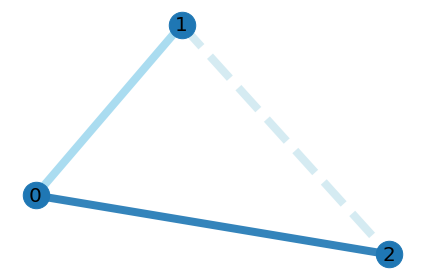

In [1]:
import networkx as nx
from matplotlib import pyplot as plt

"""INPUTS -- ENTER NUMBER OF NODES AND EDGE SPECIFICATIONS HERE"""
nodes = range(3) # Insert the number of nodes on your graph in the range function
# Each edge in following array is formatted as (start_node, end_node, weight)
E     =[(0,1,0.5), (1,2,0.2), (2,0,0.8)]
# End of input area

### Visualize graph
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(E)

def draw_networkx(colors=None):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.7]
    emedium = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.7 and d["weight"] > 0.4]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.4]

    pos          = nx.spring_layout(G, seed=7)
    default_axis = plt.axes(frameon=False)

    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=8, alpha=0.9, edge_color="tab:blue")
    nx.draw_networkx_edges(G, pos, edgelist=emedium, width=8, alpha=0.7, edge_color="skyblue")
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=8, alpha=0.5, edge_color="lightblue", style="dashed")
    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=colors)
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
draw_networkx()

In [2]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

In [3]:
# Defines the list of qubits
num = len(nodes)
depth = 4
shots = 1024
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

"""Initializes all qubits into uniform superposition"""
def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [4]:
"""Defines the cost unitary -- encodes time evolution of cost Hamiltonian"""
def cost_unitary(qubits, gamma):
    for i in E:
        start_node = i[0]    #start node of edge
        end_node = i[1]      #end node of edge
        w = i[2]             #weight of edge
        # Encoding time evolution operator (exponentiated cost Hamiltonian) onto circuit
        yield cirq.ZZPowGate(exponent=-1*w*gamma/math.pi).on(qubits[start_node], qubits[end_node])

"""Defines the mixer unitary -- encodes time evolution of Hamiltonian that doesn't commute with cost Hamiltonian"""
def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        # Increasing the probability of measurement for states marked by cost unitary 
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [5]:
"""Executes the circuit"""
def create_circuit(params):
    gamma = [params[0], params[2], params[4], params[6]] # parameters for each cost layer
    alpha = [params[1], params[3], params[5], params[7]] # parameters for each mixer layer

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits)) # Initializing all qubits by applying a Hadamard transform
    
    """For each layer, append a cost layer and a mixer layer to the circuit consecutively with the matching parameters"""
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    
    circuit.append(cirq.measure(*qubits, key='x')) # Measure the circuit

    """Conducts several shots of the circuit to inspect probability distribution and output bitstrings that were measured"""
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=shots)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, shots):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)
    return new_res

Now, we are able to create our cost function, in order to post-process the data measured from the quantum circuit executions. The cost function we made here returns a negative value (dependant on the weight) if the nodes are coloured differently and returns 0 if they are coloured the same. Thus, the objective is to minimize the cost function.

In [6]:
"""Defines the cost function -- runs one epoch"""
def cost_function(params): 
    res = create_circuit(params)
    total_cost = 0
    """Iterate over each result"""
    for i in range(0, len(res)):
        """Iterate over each edge in each result"""
        for j in E:
            start_node = j[0]
            end_node = j[1]
            w = j[2]
            """Calculate the cost of each edge and add it to the total cost"""
            total_cost = total_cost + -1*(w*res[i][start_node]*(1-res[i][end_node]) + w*res[i][end_node]*(1-res[i][start_node]))
    
    """Calculates the average cost over 1000 repitions of the algorithm"""
    total_cost = float(total_cost)/shots 
    print("Cost: "+str(total_cost))

    return total_cost

In [7]:
"""Defines a classical optimizer to tune the gamma and alpha parameters to minimize the expected value of the cost function"""
init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
print("Cost minimization: \n--------------------------")
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})

optimal_params = out['x']
f = create_circuit(optimal_params)

Cost minimization: 
--------------------------
Cost: -0.8538085937499951
Cost: -0.5631835937500003
Cost: -0.2087890624999998
Cost: -0.54345703125
Cost: -1.108886718749988
Cost: -0.8933593749999912
Cost: -0.8572265624999955
Cost: -1.0756835937499913
Cost: -0.44179687500000137
Cost: -0.4959960937500023
Cost: -1.1374999999999882
Cost: -1.1358398437499886
Cost: -1.0105468749999986
Cost: -1.191113281249985
Cost: -1.1601562499999862
Cost: -1.1182617187499897
Cost: -1.097558593749986
Cost: -1.158593749999986
Cost: -1.1954101562499821
Cost: -1.218749999999981
Cost: -1.173046874999982
Cost: -1.2312499999999809
Cost: -1.1737304687499825
Cost: -1.2474609374999797
Cost: -1.2161132812499809
Cost: -1.2424804687499802
Cost: -1.1970703124999824
Cost: -1.2457031249999795
Cost: -1.2153320312499811
Cost: -1.177929687499982
Cost: -1.2344726562499804
Cost: -1.2472656249999794
Cost: -1.22880859374998
Cost: -1.2494140624999794
Cost: -1.2477539062499792
Cost: -1.2409179687499803
Cost: -1.24257812499998
Cost: 

In [8]:
"""Given a list of results and corresponding frequency, this function outputs the 2 solutions"""
def get_max_and_secondmax(freq, nums, want_second_max):
    first_solution = nums[freq.index(np.amax(freq))]

    mx=max(freq[0],freq[1]) 
    secondmax=min(freq[0],freq[1])
    n =len(freq)
    for i in range(2,n):
        if freq[i]>mx: 
            secondmax=mx
            mx=freq[i] 
        elif freq[i]>secondmax and \
            mx != freq[i]: 
            secondmax=freq[i]
    second_solution = nums[freq.index(secondmax)]
    
    if want_second_max == "Yes":
        return first_solution, second_solution
    else:
        return first_solution

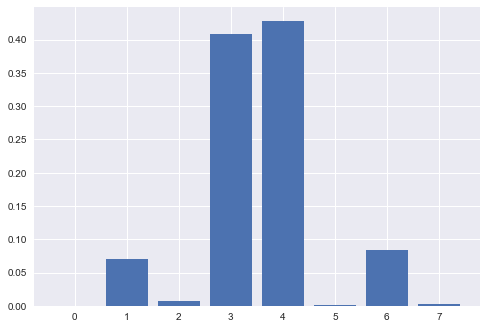

In [9]:
"""Plots histogram of results from optimized QAOA circuit"""
nums = []
freq = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    number = 0
    # Converting result bit string into integer value
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    # Recording result
    if (number in nums):
        freq[nums.index(number)] += 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq] # Scaling frequencies to sum to one

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.style.use("seaborn")
plt.bar(x, y)
plt.show()

Above you can see a histogram showing the probabilities corresponding to each bitstring. Since this has been run on the optimal parameters, we know that the two states with the highest probability of being measured are the solutions to our weighted max-cut problem! As you can see, in this simple case the states with highest probability of measurement are $|3⟩ = |011⟩$ and $|4⟩ = |100⟩$. Notice why we have *two* optimal solutions, both $|2\rangle$ and $|13\rangle$ have the maximum cut. This is because the  actual set a given node belongs to doesn't matter as long as the difference between the node sets stays the same. Thus, $|011\rangle$ and $|100\rangle$ have the same cut! I implore you to check it on your own.

In [10]:
top_int_solution, second_int_solution = get_max_and_secondmax(freq, nums, "Yes")
print(f"\n --------------------------------------------------------------------------------------------------------------------\
---------- \n  The two solutions for your weighted max-cut graph is {top_int_solution} \
({np.binary_repr(top_int_solution, width=len(f[100]))}) and {second_int_solution} \
({np.binary_repr(second_int_solution, width=len(f[100]))})!\n -------------------------------------------------------------\
----------------------------------------------------------------- \n")


 ------------------------------------------------------------------------------------------------------------------------------ 
  The two solutions for your weighted max-cut graph is 4 (100) and 3 (011)!
 ------------------------------------------------------------------------------------------------------------------------------ 



In [11]:
"""Retrieving top solution in binary--value indicates which set the node belongs to"""
nums_bin = []
freq_bin = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    # Recording result
    if (f[i] in nums_bin):
        freq_bin[nums_bin.index(f[i])] += 1
    else:
        nums_bin.append(f[i])
        freq_bin.append(1)
top_bin_solution = get_max_and_secondmax(freq_bin, nums_bin, "No")

Solution graph (4 [1, 0, 0]):


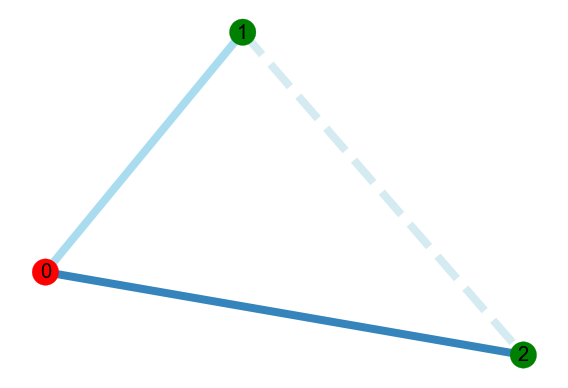

In [12]:
"""Visualizing graph with Max-Cut colouring"""
colors = [] #setting up a list of colors
for node in top_bin_solution:
    if node == 0:
        colors.append("green")
    else:
        colors.append("red")

print(f"Solution graph ({top_int_solution} {top_bin_solution}):")
draw_networkx(colors)

# Example with new graph

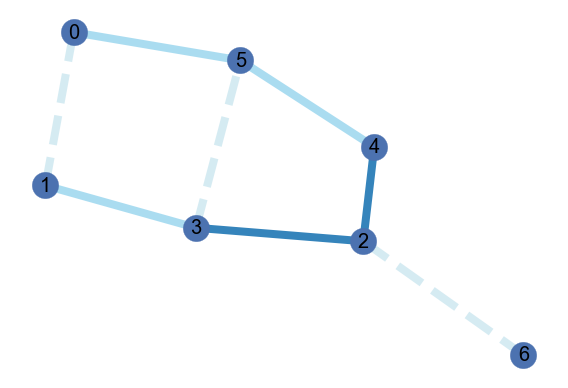

In [13]:
"""INPUTS -- ENTER NUMBER OF NODES AND EDGE SPECIFICATIONS HERE"""
nodes = range(7) # Insert the number of nodes on your graph in the range function
# Each edge in following array is formatted as (start_node, end_node, weight)
E     =[(0,1,0.2), (0,5,0.5), (1,3,0.7), (2,6,0.3), (2,3,0.8), (2,4,1), (3,5,0.1), (4,5,0.5)]
# End of input area

### Visualize graph
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(E)

draw_networkx()

In [14]:
# Defines the list of qubits
num = len(nodes)
depth = 4
shots = 1024
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

"""Defines a classical optimizer to tune the gamma and alpha parameters to minimize the expected value of the cost function"""
init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
print("Cost minimization: \n--------------------------")
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})

optimal_params = out['x']
f = create_circuit(optimal_params)

Cost minimization: 
--------------------------
Cost: -1.7484374999999905
Cost: -1.5180664062499925
Cost: -2.0736328124999863
Cost: -1.787109374999985
Cost: -2.0645507812499884
Cost: -2.1103515624999853
Cost: -2.547265624999982
Cost: -2.3293945312499744
Cost: -2.2716796874999727
Cost: -2.2256835937499644
Cost: -2.66484374999999
Cost: -2.5698242187499782
Cost: -2.5552734374999817
Cost: -2.493945312499981
Cost: -2.8056640624999822
Cost: -2.9702148437499742
Cost: -3.008300781249969
Cost: -3.0488281249999845
Cost: -3.0021484374999807
Cost: -2.8073242187499856
Cost: -3.2949218749999662
Cost: -3.1220703124999627
Cost: -3.236816406249974
Cost: -3.1053710937499712
Cost: -3.327246093749967
Cost: -3.3103515624999647
Cost: -3.2953124999999774
Cost: -3.1264648437499827
Cost: -3.154980468749972
Cost: -3.2319335937499756
Cost: -3.2587890624999796
Cost: -3.2966796874999797
Cost: -3.3009765624999745
Cost: -3.305078124999975
Cost: -3.303906249999976
Cost: -3.328222656249975
Cost: -3.3635742187499726
Cos

In [15]:
"""Retrieving top solution in binary--value indicates which set the node belongs to"""
nums_bin = []
freq_bin = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    # Recording result
    if (f[i] in nums_bin):
        freq_bin[nums_bin.index(f[i])] += 1
    else:
        nums_bin.append(f[i])
        freq_bin.append(1)
top_bin_solution = get_max_and_secondmax(freq_bin, nums_bin, "No")

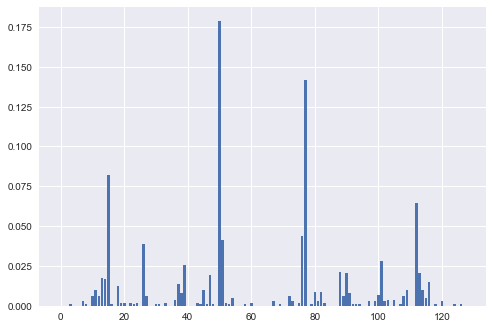


 ------------------------------------------------------------------------------------------------------------------------------ 
  The two solutions for your weighted max-cut graph is 50 (0110010) and 77 (1001101)!
 ------------------------------------------------------------------------------------------------------------------------------ 



In [16]:
nums = []
freq = []

### Iterating through all results and calculating frequency of results
for i in range(0, len(f)):
    number = 0
    # Converting result bit string into integer value
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    # Recording result
    if (number in nums):
        freq[nums.index(number)] += 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq] 

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.style.use("seaborn")
plt.bar(x, y)
plt.show()

top_int_solution, second_int_solution = get_max_and_secondmax(freq, nums, "Yes")
print(f"\n --------------------------------------------------------------------------------------------------------------------\
---------- \n  The two solutions for your weighted max-cut graph is {top_int_solution} \
({np.binary_repr(top_int_solution, width=len(f[100]))}) and {second_int_solution} \
({np.binary_repr(second_int_solution, width=len(f[100]))})!\n -------------------------------------------------------------\
----------------------------------------------------------------- \n")

Solution graph colouring (50 [0, 1, 1, 0, 0, 1, 0]):


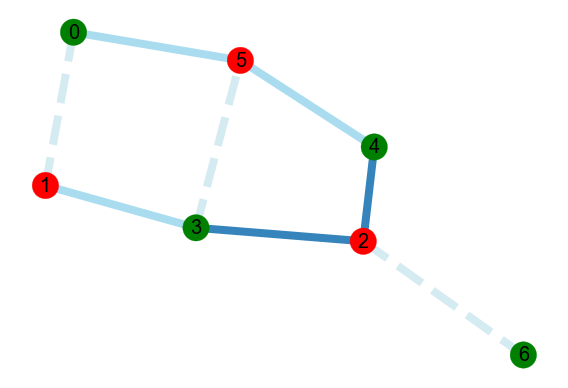

In [17]:
"""Visualizing graph with Max-Cut colouring"""
colors = [] #setting up a list of colors
for node in top_bin_solution:
    if node == 0:
        colors.append("green")
    else:
        colors.append("red")

print(f"Solution graph colouring ({top_int_solution} {top_bin_solution}):")
draw_networkx(colors=colors)